<a href="https://colab.research.google.com/github/vkislinskii/m598_intermittent_demand_forecasting/blob/main/M5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Importing libraries

In [14]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

!pip install statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoETS, CrostonOptimized, TSB, ADIDA, IMAPA
from xgboost import XGBRegressor

! pip install catboost
from catboost import CatBoostClassifier, CatBoostRegressor
from catboost import Pool

#1. Reading data

In [15]:
# чек основного куска данных
drive.mount('/content/drive')
df_data = pd.read_csv("/content/drive/MyDrive/202507_thesis/data - m5/sales_train_evaluation.csv")
calendar = pd.read_csv("/content/drive/MyDrive/202507_thesis/data - m5/calendar.csv")
sell_prices = pd.read_csv("/content/drive/MyDrive/202507_thesis/data - m5/sell_prices.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Preprocessing data

In [16]:
#function to reduce the dataset size
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= 0:
                    if c_max < 255:
                        df[col] = df[col].astype('uint8')
                    elif c_max < 65535:
                        df[col] = df[col].astype('uint16')
                    elif c_max < 4294967295:
                        df[col] = df[col].astype('uint32')
                    else:
                        df[col] = df[col].astype('uint64')
                else:
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype('int8')
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype('int16')
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype('int32')
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')
        else:
            df[col] = df[col].astype('category')
    return df

In [17]:
calendar = calendar[['d', 'wm_yr_wk', 'weekday', 'month', 'year', 'event_name_1', 'snap_CA', 'snap_TX', 'snap_WI']]
df_data.dept_id = df_data.dept_id.str[-1:]

In [18]:
calendar_small = reduce_mem_usage(calendar).copy()
sell_prices_small = reduce_mem_usage(sell_prices).copy()
df_data_small = reduce_mem_usage(df_data).copy()
del calendar
del sell_prices
del df_data

In [19]:
#transposing the table
id_vars = ['id', 'item_id',	'dept_id',	'cat_id',	'store_id',	'state_id']
value_vars = df_data_small.select_dtypes(include=['uint8', 'uint16']).columns
df_data2 = df_data_small.melt(id_vars=id_vars, value_vars=value_vars, var_name="d", value_name="y")

df_data_small = pd.DataFrame(None)
df_data2['ds'] = pd.to_numeric(df_data2.d.str[2:]).astype('uint16')
df_data2['d'] = df_data2['d'].astype('category')
df_data2 = df_data2.rename(columns={"id": "unique_id"})

In [20]:
#joining the calendar iteratively
chunk_size = 5_000_000
chunks = []

for start in range(0, len(df_data2), chunk_size):
    end = start + chunk_size
    chunk = df_data2.iloc[start:end].merge(calendar_small, on='d', how='left')
    chunks.append(chunk)

df_data2 = pd.concat(chunks, ignore_index=True)

In [21]:
#joining the prices iteratively
chunk_size = 5_000_000
chunks = []

for start in range(0, len(df_data2), chunk_size):
    end = start + chunk_size
    chunk = df_data2.iloc[start:end].merge(sell_prices_small, on=["store_id", "item_id", "wm_yr_wk"], how='left')
    chunks.append(chunk)

df_data2 = pd.concat(chunks, ignore_index=True)
chunks = []

In [22]:
del calendar_small
del sell_prices_small
del chunk
df_data2 = df_data2.drop(columns='d')

In [23]:
#make the first non-zero demand the initial value
df_data_fin_start = df_data2.query("y != 0")[['unique_id', 'ds']].groupby(by="unique_id", observed=False, as_index=False).min().rename(columns={"ds": "ds_start"})
df_data2 = df_data2.merge(df_data_fin_start, on=['unique_id'], how='left').query("ds >= ds_start")
df_data_fin = df_data2[['unique_id', 'ds', 'y']]

#3. Data exploration

In [ ]:
df_plot = df_data2.pivot(index="ds", columns="unique_id", values="y").fillna(0)

In [ ]:
def compute_p_v_from_series(series: pd.Series, ddof: int = 1):
    series = series.dropna()
    T = len(series)
    positives = series[series > 0]
    m = int(positives.count())
    if m == 0:
        return {"T": T, "m": 0, "p": np.nan, "mu": np.nan, "var": np.nan, "v": np.nan}
    p = T / m
    mu = float(positives.mean())
    if m > ddof:
        var = float(positives.var(ddof=ddof))
        v = var / (mu**2) if mu != 0 else np.inf
    else:
        var = np.nan
        v = np.nan
    return {"T": T, "m": m, "p": p, "mu": mu, "var": var, "v": v}

In [ ]:
ddof=1
sort_by='p'
results = []

for col in df_plot.columns:
  res = compute_p_v_from_series(df_plot[col], ddof=ddof)
  res["item"] = col
  results.append(res)

results_df = pd.DataFrame(results).set_index("item")
results_df = results_df[["T", "m", "p", "mu", "var", "v"]]

if sort_by in results_df.columns:
  results_df_sorted = results_df.sort_values(sort_by, ascending=False)
else:
  results_df_sorted = results_df.copy()

results_df_sorted['ln_p'] = np.log(results_df_sorted.p)
results_df_sorted['ln_v'] = np.log(results_df_sorted.v)

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
smo = results_df_sorted.query("p <= 1.32 & v <= 0.49").shape[0]
inte = results_df_sorted.query("p > 1.32 & v <= 0.49").shape[0]
err = results_df_sorted.query("p <= 1.32 & v > 0.49").shape[0]
lum = results_df_sorted.query("p > 1.32 & v > 0.49").shape[0]

print(f"{smo} - Smooth \n{inte} - Intermittent\n{err} - Erratic\n{lum} - Lumpy")

983 - Smooth 
23075 - Intermittent
494 - Erratic
5938 - Lumpy


In [ ]:
round(results_df_sorted[['p', 'v']].describe(), 2)

,p,v
count,30490.00,30490.00
mean,6.33,0.39
std,7.60,0.69
min,1.00,0.00
25%,2.15,0.23
50%,3.75,0.35
75%,7.41,0.46
max,161.75,106.75


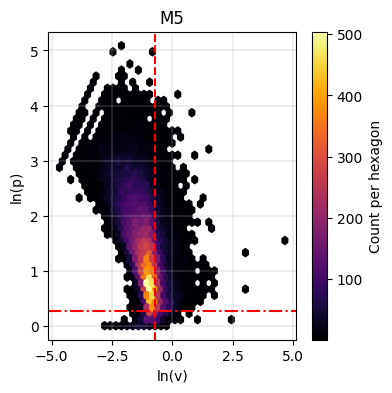

In [ ]:
y = results_df_sorted["ln_p"].values
x = results_df_sorted["ln_v"].values
labels = results_df_sorted.index.astype(str).tolist()

fig, ax = plt.subplots(figsize=(4, 4))
hb = ax.hexbin(x, y, gridsize=40, cmap="inferno", mincnt=1)

ax.set_ylabel("ln(p)") #p - average inter-demand interval
ax.set_xlabel("ln(v)") #v - squared coef of variation
ax.set_title("M5")

ax.grid(True, linewidth=0.3)

v_thresh = 0.27763
p_thresh = -0.71334

# vertical and horizontal lines at the borders
ax.axvline(x=p_thresh, color="red", linestyle="--", linewidth=1.5, label=f"p = {p_thresh}")
ax.axhline(y=v_thresh, color="red", linestyle="-.", linewidth=1.5, label=f"v = {v_thresh}")

plt.colorbar(hb, ax=ax, label="Count per hexagon")

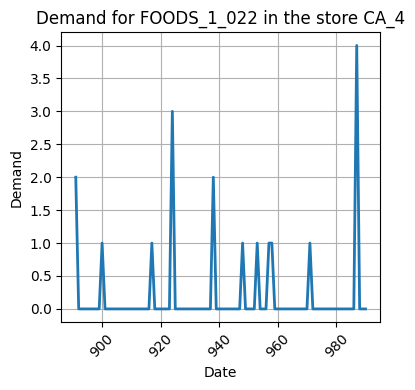

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(df_data2.query("unique_id == 'FOODS_1_022_CA_4_evaluation'").ds[:100], df_data2.query("unique_id == 'FOODS_1_022_CA_4_evaluation'").y[:100], linestyle="-", linewidth=2)

# Labels and title
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Demand for FOODS_1_022 in the store CA_4")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

#4. Feature engineering

In [24]:
h = 28
split_day = int(df_data2.ds.max() - h)

In [25]:
#train-test for univariate models
train = df_data_fin.query("ds <= @split_day")
test = df_data_fin.query("ds > @split_day")

#5. Predictions

##5.1. RMSSE metric function defining

In [26]:
#RMSSE metric calculation
def fast_rmsse(df_hist, df_forecasts, df_test, forecast_col):
    hist_df = df_hist.pivot(index='ds', columns='unique_id', values='y').sort_index()
    test_df = df_test.pivot(index='ds', columns='unique_id', values='y').sort_index()
    pred_df = df_forecasts.pivot(index='ds', columns='unique_id', values=forecast_col).sort_index()

    #align columns across datsframes
    cols = hist_df.columns
    test_df = test_df.reindex(columns=cols)
    pred_df = pred_df.reindex(columns=cols)

    #convert to numpy for calculation
    hist_wide = hist_df.to_numpy(dtype=float)
    test_wide = test_df.to_numpy(dtype=float)
    pred_wide = pred_df.to_numpy(dtype=float)

    #denominator
    diffsq = np.diff(hist_wide, axis=0) ** 2
    denom = np.nanmean(diffsq, axis=0)

    #numerator (mean squared forecast errors)
    num = np.nanmean((test_wide - pred_wide) ** 2, axis=0)

    #calculation
    bad = (denom == 0) | np.isnan(denom)
    rmsse = np.sqrt(num / denom)
    rmsse[bad] = np.nan

    return rmsse, cols

##5.2. ETS, SBA, TSB, ADIDA, IMAPA

In [27]:
sf = StatsForecast(
    models=[
        CrostonOptimized(alias='SBA'),
        TSB(alpha_d=0.2, alpha_p=0.2),
        ADIDA(),
        IMAPA(),
        AutoETS(season_length=12, model="ANN")
        ],
    freq=1,
    n_jobs=1
)

In [28]:
fitted = sf.fit(train)
forecasts = fitted.forecast(df=train, h=h)

In [34]:
merged = forecasts.merge(test, on=['unique_id', 'ds'], how='left')
merged['SBA_round'] = np.round(merged['SBA']).astype('uint16')
merged['TSB_round'] = np.round(merged['TSB']).astype('uint16')
merged['ADIDA_round'] = np.round(merged['ADIDA']).astype('uint16')
merged['IMAPA_round'] = np.round(merged['IMAPA']).astype('uint16')
merged['ETS_round'] = np.round(merged['AutoETS']).astype('int16')

In [35]:
#RMSSE - float prediction
r_vec_sba, cols_sba = fast_rmsse(train, merged, test, 'SBA')
r_vec_tsb, cols_tsb = fast_rmsse(train, merged, test, 'TSB')
r_vec_adida, cols_adida = fast_rmsse(train, merged, test, 'ADIDA')
r_vec_imapa, cols_imapa = fast_rmsse(train, merged, test, 'IMAPA')
r_vec_ets, cols_ets = fast_rmsse(train, merged, test, 'AutoETS')

print(f"RMSSE CrostonSBA: {np.nanmean(r_vec_sba):.3f}")
print(f"RMSSE TSB: {np.nanmean(r_vec_tsb):.3f}")
print(f"RMSSE ADIDA: {np.nanmean(r_vec_adida):.3f}")
print(f"RMSSE IMAPA: {np.nanmean(r_vec_imapa):.3f}")
print(f"RMSSE ETS: {np.nanmean(r_vec_ets):.3f}")

RMSSE CrostonSBA: 0.771
RMSSE TSB: 0.780
RMSSE ADIDA: 0.763
RMSSE IMAPA: 0.764
RMSSE ETS: 0.763


In [36]:
#RMSSE - integer prediction
r_vec_sba, cols_sba = fast_rmsse(train, merged, test, 'SBA_round')
r_vec_tsb, cols_tsb = fast_rmsse(train, merged, test, 'TSB_round')
r_vec_adida, cols_adida = fast_rmsse(train, merged, test, 'ADIDA_round')
r_vec_imapa, cols_imapa = fast_rmsse(train, merged, test, 'IMAPA_round')
r_vec_ets, cols_ets = fast_rmsse(train, merged, test, 'ETS_round')

print(f"RMSSE CrostonSBA: {np.nanmean(r_vec_sba):.3f}")
print(f"RMSSE TSB: {np.nanmean(r_vec_tsb):.3f}")
print(f"RMSSE ADIDA: {np.nanmean(r_vec_adida):.3f}")
print(f"RMSSE IMAPA: {np.nanmean(r_vec_imapa):.3f}")
print(f"RMSSE ETS: {np.nanmean(r_vec_ets):.3f}")

RMSSE CrostonSBA: 0.809
RMSSE TSB: 0.815
RMSSE ADIDA: 0.801
RMSSE IMAPA: 0.802
RMSSE ETS: 0.801


In [37]:
#MAE - float prediction
mae_sba = mean_absolute_error(merged['y'], merged['SBA'])
mae_tsb = mean_absolute_error(merged['y'], merged['TSB'])
mae_adida = mean_absolute_error(merged['y'], merged['ADIDA'])
mae_imapa = mean_absolute_error(merged['y'], merged['IMAPA'])
mae_ets = mean_absolute_error(merged['y'], merged['AutoETS'])

print(f"MAE CrostonSBA: {mae_sba:.3f}")
print(f"MAE TSB: {mae_tsb:.3f}")
print(f"MAE ADIDA: {mae_adida:.3f}")
print(f"MAE IMAPA: {mae_imapa:.3f}")
print(f"MAE ETS: {mae_ets:.3f}")

MAE CrostonSBA: 1.092
MAE TSB: 1.072
MAE ADIDA: 1.060
MAE IMAPA: 1.061
MAE ETS: 1.063


In [38]:
#MAE - integer prediction
mae_sba = mean_absolute_error(merged['y'], merged['SBA_round'])
mae_tsb = mean_absolute_error(merged['y'], merged['TSB_round'])
mae_adida = mean_absolute_error(merged['y'], merged['ADIDA_round'])
mae_imapa = mean_absolute_error(merged['y'], merged['IMAPA_round'])
mae_ets = mean_absolute_error(merged['y'], merged['ETS_round'])

print(f"MAE CrostonSBA: {mae_sba:.3f}")
print(f"MAE TSB: {mae_tsb:.3f}")
print(f"MAE ADIDA: {mae_adida:.3f}")
print(f"MAE IMAPA: {mae_imapa:.3f}")
print(f"MAE ETS: {mae_ets:.3f}")

MAE CrostonSBA: 1.044
MAE TSB: 1.035
MAE ADIDA: 1.013
MAE IMAPA: 1.016
MAE ETS: 1.015
